In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [3]:
GPU_cuda_no = 0

cuda_no = 'cuda:'+str(GPU_cuda_no)

device = torch.device(cuda_no if torch.cuda.is_available() else 'cpu')

In [4]:
ticker = 'META'
data = yf.download(ticker, period="5y")
prices = data['Close'].values
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-08-08  186.619995  190.339996  184.050003  190.160004  189.770035   
2019-08-09  190.000000  190.979996  187.119995  187.850006  187.464783   
2019-08-12  186.850006  187.589996  184.460007  185.369995  184.989853   
2019-08-13  185.520004  191.380005  185.369995  188.449997  188.063538   
2019-08-14  185.800003  185.990005  179.309998  179.710007  179.341476   

              Volume  
Date                  
2019-08-08  14828900  
2019-08-09  11058800  
2019-08-12  10930900  
2019-08-13  13577000  
2019-08-14  18903700  


In [5]:
window_size = 30
X, y = [], []
for i in range(len(prices) - window_size):
    X.append(prices[i:i+window_size])
    y.append(prices[i+window_size])
X, y = np.array(X), np.array(y)

In [6]:
X_train, y_train = torch.tensor(X[:-365], dtype=torch.float32), torch.tensor(y[:-365], dtype=torch.float32)
X_test, y_test = torch.tensor(X[-365:], dtype=torch.float32), torch.tensor(y[-365:], dtype=torch.float32)

In [7]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
class neuralNetworkOneLayer(nn.Module):
    def __init__(self):
        super(neuralNetworkOneLayer, self).__init__()
        self.fc1 = nn.Linear(window_size, 2*window_size)
        self.fc2 = nn.Linear(2*window_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
learning_rate = 0.001

In [11]:
OneLayer = neuralNetworkOneLayer() #.to(device)
criterion = nn.MSELoss() #.to(device)
optimizer = optim.Adam(OneLayer.parameters(), lr=learning_rate)

In [12]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

In [14]:
def calculate_accuracy(y_true, y_pred):
    return torch.mean(1 - torch.abs((y_true - y_pred) / y_true))

In [15]:
total_step = len(train_loader)
start_time = time.time()

In [16]:
epochs = 500
for epoch in range(epochs):
    OneLayer.train()
    running_loss, running_acc = 0.0, 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = OneLayer(X_batch)
        loss = criterion(outputs, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        running_acc += calculate_accuracy(y_batch.view(-1, 1), outputs).item() * X_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_acc / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    OneLayer.eval()
    running_val_loss, running_val_acc = 0.0, 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = OneLayer(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))
            running_val_loss += loss.item() * X_batch.size(0)
            running_val_acc += calculate_accuracy(y_batch.view(-1, 1), outputs).item() * X_batch.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = running_val_acc / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch [1/500], Loss: 25392.5699, Val Loss: 711.3610, Acc: 0.4635, Val Acc: 0.9518
Epoch [51/500], Loss: 143.2440, Val Loss: 217.6449, Acc: 0.9585, Val Acc: 0.9722
Epoch [101/500], Loss: 84.0323, Val Loss: 130.2125, Acc: 0.9694, Val Acc: 0.9781
Epoch [151/500], Loss: 62.5659, Val Loss: 103.3037, Acc: 0.9747, Val Acc: 0.9814
Epoch [201/500], Loss: 57.1221, Val Loss: 91.9789, Acc: 0.9762, Val Acc: 0.9825
Epoch [251/500], Loss: 54.9383, Val Loss: 100.2227, Acc: 0.9766, Val Acc: 0.9810
Epoch [301/500], Loss: 62.0054, Val Loss: 90.9596, Acc: 0.9747, Val Acc: 0.9824
Epoch [351/500], Loss: 51.5275, Val Loss: 87.2880, Acc: 0.9777, Val Acc: 0.9829
Epoch [401/500], Loss: 51.3661, Val Loss: 126.9815, Acc: 0.9778, Val Acc: 0.9773
Epoch [451/500], Loss: 56.7656, Val Loss: 96.3596, Acc: 0.9762, Val Acc: 0.9816
Epoch [500/500], Loss: 48.2644, Val Loss: 84.5935, Acc: 0.9784, Val Acc: 0.9837


In [17]:
training_time = time.time() - start_time
print(f'Training time: {training_time:.2f} seconds')

Training time: 12.01 seconds


In [18]:
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')
print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

Final Training Loss: 48.2644
Final Validation Loss: 84.5935
Final Training Accuracy: 0.9784
Final Validation Accuracy: 0.9837


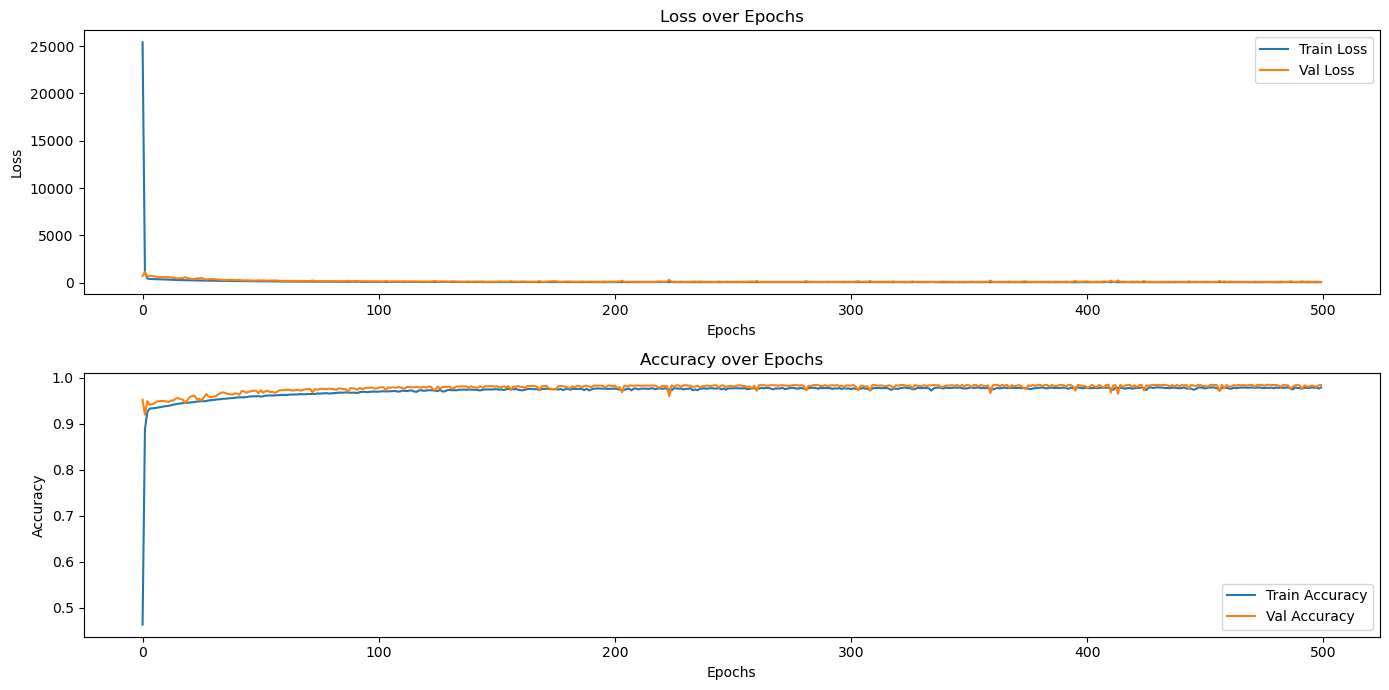

In [19]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


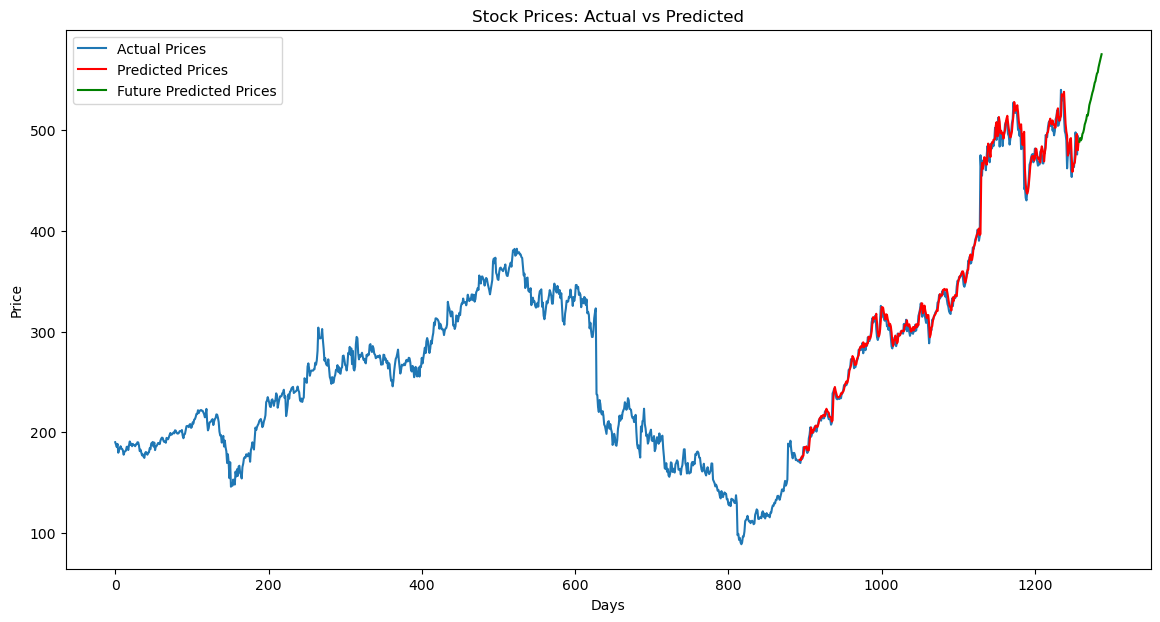

In [20]:
OneLayer.eval()
with torch.no_grad():
    future_days = 30
    future_prices = []
    input_seq = X_test[-1].numpy()
    for _ in range(future_days):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        predicted_price = OneLayer(input_tensor).item()
        future_prices.append(predicted_price)
        input_seq = np.append(input_seq[1:], predicted_price)
    

plt.figure(figsize=(14, 7))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(prices) - 365, len(prices)), OneLayer(X_test).detach().numpy(), label='Predicted Prices', color='red')
plt.plot(range(len(prices), len(prices) + future_days), future_prices, label='Future Predicted Prices', color='green')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Stock Prices: Actual vs Predicted')
plt.show()

In [21]:
num_params_nn = sum(p.numel() for p in OneLayer.parameters() if p.requires_grad)
num_params_nn

1921

In [22]:
class neuralNetworkThreeLayer(nn.Module):
    def __init__(self):
        super(neuralNetworkThreeLayer, self).__init__()
        self.fc1 = nn.Linear(window_size, 2*window_size)
        self.fc2 = nn.Linear(2*window_size, 4*window_size)
        self.fc3 = nn.Linear(4*window_size, window_size)
        self.fc4 = nn.Linear(window_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [23]:
ThreeLayer = neuralNetworkThreeLayer()
optimizer = optim.Adam(ThreeLayer.parameters(), lr=0.01)

In [24]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

In [25]:
total_step = len(train_loader)
start_time = time.time()

In [26]:
epochs = 500
for epoch in range(epochs):
    ThreeLayer.train()
    running_loss, running_acc = 0.0, 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = ThreeLayer(X_batch)
        loss = criterion(outputs, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        running_acc += calculate_accuracy(y_batch.view(-1, 1), outputs).item() * X_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_acc / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    ThreeLayer.eval()
    running_val_loss, running_val_acc = 0.0, 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = ThreeLayer(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))
            running_val_loss += loss.item() * X_batch.size(0)
            running_val_acc += calculate_accuracy(y_batch.view(-1, 1), outputs).item() * X_batch.size(0)


    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = running_val_acc / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch [1/500], Loss: 6401.6506, Val Loss: 2117.9923, Acc: 0.7567, Val Acc: 0.8838
Epoch [51/500], Loss: 132.4532, Val Loss: 140.7653, Acc: 0.9612, Val Acc: 0.9758
Epoch [101/500], Loss: 64.2267, Val Loss: 230.6515, Acc: 0.9740, Val Acc: 0.9656
Epoch [151/500], Loss: 95.6797, Val Loss: 136.5658, Acc: 0.9676, Val Acc: 0.9760
Epoch [201/500], Loss: 84.6897, Val Loss: 175.7210, Acc: 0.9701, Val Acc: 0.9715
Epoch [251/500], Loss: 70.4183, Val Loss: 81.9032, Acc: 0.9729, Val Acc: 0.9839
Epoch [301/500], Loss: 71.0826, Val Loss: 80.9352, Acc: 0.9727, Val Acc: 0.9840
Epoch [351/500], Loss: 56.9406, Val Loss: 96.0166, Acc: 0.9759, Val Acc: 0.9817
Epoch [401/500], Loss: 86.5483, Val Loss: 407.5259, Acc: 0.9688, Val Acc: 0.9509
Epoch [451/500], Loss: 53.4865, Val Loss: 157.0622, Acc: 0.9768, Val Acc: 0.9733
Epoch [500/500], Loss: 81.5853, Val Loss: 241.1489, Acc: 0.9703, Val Acc: 0.9643


In [27]:
training_time = time.time() - start_time
print(f'Training time: {training_time:.2f} seconds')

Training time: 19.76 seconds


In [28]:
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')
print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

Final Training Loss: 81.5853
Final Validation Loss: 241.1489
Final Training Accuracy: 0.9703
Final Validation Accuracy: 0.9643


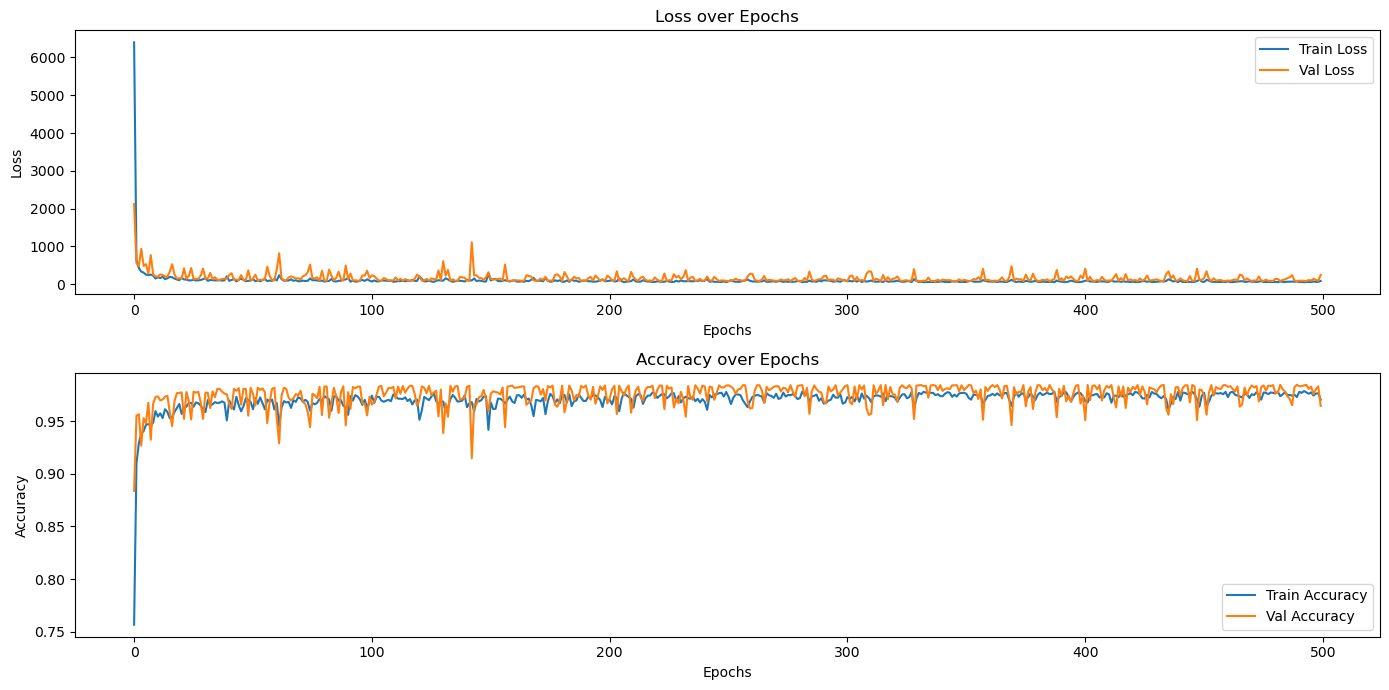

In [29]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

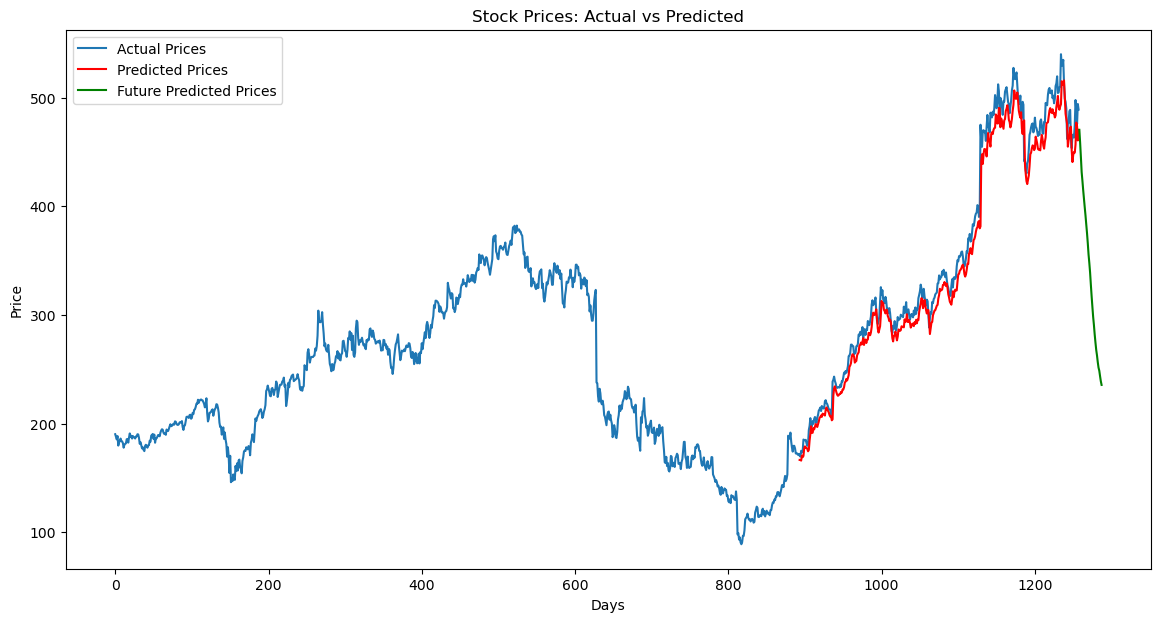

In [30]:
ThreeLayer.eval()
with torch.no_grad():
    future_days = 30
    future_prices = []
    input_seq = X_test[-1].numpy()
    for _ in range(future_days):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        predicted_price = ThreeLayer(input_tensor).item()
        future_prices.append(predicted_price)
        input_seq = np.append(input_seq[1:], predicted_price)
    

plt.figure(figsize=(14, 7))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(prices) - 365, len(prices)), ThreeLayer(X_test).detach().numpy(), label='Predicted Prices', color='red')
plt.plot(range(len(prices), len(prices) + future_days), future_prices, label='Future Predicted Prices', color='green')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Stock Prices: Actual vs Predicted')
plt.show()

In [31]:
num_params_nn = sum(p.numel() for p in ThreeLayer.parameters() if p.requires_grad)
num_params_nn

12841